In [1]:
import pandas as pd
pd.options.display.max_columns=999

In [2]:
elo_df=pd.read_csv("data/nfl-elo/nfl_elo.csv")
elo_df=elo_df.loc[elo_df['season']>=1966]#super bowl era only
elo_df['date']=pd.to_datetime(elo_df['date'])
elo_df

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
3821,1966-09-02,1966,0,NaN,MIA,OAK,1300.000000,1523.365000,0.286668,0.713332,1287.685000,1535.681000,1300.000000,1523.320809,Dick Wood,Cotton Davidson,73.282973,89.764573,-14.938970,1.977796,0.267553,0.732447,-182.853892,-154.440000,47.669287,65.344116,1288.586376,1534.734433,14,23,6.0,NaN,NaN
3822,1966-09-03,1966,0,NaN,TEN,DEN,1377.030000,1382.690000,0.584576,0.415424,1406.669000,1353.051000,1376.304495,1383.369283,George Blanda,Mickey Slaughter,33.816121,49.238303,-7.915569,-4.015832,0.568825,0.431175,231.294855,-55.911447,53.563994,38.723328,1407.220870,1352.452907,45,7,3.0,NaN,NaN
3823,1966-09-04,1966,0,NaN,LAC,BUF,1542.653000,1619.002000,0.483673,0.516327,1574.255000,1587.400000,1539.488456,1621.746408,John Hadl,Jack Kemp,101.310079,79.030950,1.958802,-0.888078,0.477464,0.522536,230.623604,-170.219562,114.241432,54.105899,1571.534146,1589.700719,27,7,84.0,NaN,NaN
3824,1966-09-09,1966,0,NaN,MIA,NYJ,1287.685000,1453.681000,0.358615,0.641385,1275.398000,1465.968000,1288.586376,1452.606478,Rick Norton,Mike Taliaferro,0.000000,-1.928381,-74.668152,-21.590926,0.258841,0.741159,23.029974,-31.053429,2.302997,-4.840886,1280.022162,1461.170692,14,19,0.0,NaN,NaN
3825,1966-09-10,1966,0,NaN,LAC,NE,1574.255000,1475.332000,0.719830,0.280170,1591.041000,1458.546000,1571.534146,1480.182564,John Hadl,Babe Parilli,114.241432,97.418512,8.326538,1.803571,0.688949,0.311051,105.405638,-190.768534,113.357853,68.599807,1590.375708,1461.341001,24,0,63.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,2022-01-23,2021,0,d,TB,LAR,1681.797158,1632.341105,0.659005,0.340995,1662.522916,1651.615346,1649.547292,1615.165080,Tom Brady,Matthew Stafford,249.882409,179.870436,11.456236,-0.623739,0.681440,0.318560,132.180809,379.027146,238.112249,199.786107,1629.446888,1635.265484,27,30,96.0,100.0,98.0
17091,2022-01-23,2021,0,d,KC,BUF,1699.470145,1683.332367,0.614689,0.385311,1713.932369,1668.870143,1687.450699,1656.910634,Patrick Mahomes,Josh Allen,273.771767,275.630099,20.577067,18.202487,0.652720,0.347280,622.042187,434.101420,308.598809,291.477231,1700.324756,1644.036577,42,36,100.0,100.0,100.0
17092,2022-01-30,2021,0,c,KC,CIN,1713.932369,1569.498961,0.769519,0.230481,1690.352000,1593.079331,1700.324756,1559.717895,Patrick Mahomes,Joe Burrow,308.598809,190.637925,36.961734,24.405309,0.810417,0.189583,134.683170,153.972640,291.207245,186.971396,1674.943733,1585.098917,24,27,98.0,100.0,99.0
17093,2022-01-30,2021,0,c,LAR,SF,1651.615346,1621.465562,0.633608,0.366392,1661.352751,1611.728157,1635.265484,1631.632019,Matthew Stafford,Jimmy Garoppolo,199.786107,117.398901,9.365284,-11.464001,0.636093,0.363907,248.504596,197.148060,204.657956,125.373817,1644.929010,1621.968494,20,17,96.0,100.0,98.0


Sports data is a bit of pain to work with. We'll need to group by season for this and evaluate the head to head rankings

In [3]:
from collections import defaultdict
import tqdm

season_records=pd.DataFrame()
#for season, season_df in tqdm.tqdm(elo_df[pd.isnull(elo_df['playoff'])].groupby("season")):
for season, season_df in tqdm.tqdm(elo_df.groupby("season")):

    win_loss_dict=defaultdict(lambda : defaultdict(int))
    adjustment_dict=defaultdict(lambda : defaultdict(lambda : defaultdict(int)))
    for idx, game in season_df.iterrows():
        win_loss_dict[game['team1']]['games_played']+=1
        win_loss_dict[game['team2']]['games_played']+=1
        if game['score1']>game['score2']:
            points_1=1
            points_2=0
        elif game['score1']<game['score2']:
            points_1=0
            points_2=1
        else:
            points_1=.5
            points_2=.5

        win_loss_dict[game['team1']]['win_pts']+=points_1
        win_loss_dict[game['team2']]['win_pts']+=points_2
        
        adjustment_dict[game['team1']][game['team2']]['games_played']-=1
        adjustment_dict[game['team2']][game['team1']]['games_played']-=1

        adjustment_dict[game['team1']][game['team2']]['win_pts']-=points_2
        adjustment_dict[game['team2']][game['team1']]['win_pts']-=points_1
        df=pd.DataFrame(win_loss_dict).T
    df['season']=season
    
    df['win_pts_rate']=df['win_pts']/df['games_played']
    
    
    #Note this uses standard elo, you could modify it to use QB Elo
    df['end_of_season_elo']=df.index.map(lambda x:
        
         pd.concat([season_df.loc[season_df['team1']==x].rename(columns={
                "elo1_post": "elo",
                }),

                    season_df.loc[season_df['team2']==x].rename(columns={
                    "elo2_post": "elo",
                        }
                   )
          
          ]).sort_values(by="date").iloc[-1]['elo']
                                                        )
    
    rows=[]
    for team in win_loss_dict.keys():
        adjustments=df.copy()
        opponents=pd.concat([season_df.loc[season_df['team1']==team].rename(columns={
                        "team2": "opponent",
                        }),

                            season_df.loc[season_df['team2']==team].rename(columns={
                            "team1": "opponent",
                                }
                           )

                  ])['opponent']
        for opponent in opponents:
            adjustments.loc[opponent,'win_pts']+=adjustment_dict[team][opponent]['win_pts']
            adjustments.loc[opponent, 'games_played']+=adjustment_dict[team][opponent]['games_played']

        adjustments['win_pts_rate']=adjustments['win_pts']/adjustments['games_played']
        rows.append({"index": team, 
                     "sos": df.loc[opponents]['win_pts_rate'].mean(),
                     "sos_adj":adjustments.loc[opponents]['win_pts_rate'].mean(),
                     "opponents": opponents.tolist()
                    })
    adjusted_rate_df=pd.DataFrame(rows).set_index("index")
    adjusted_rate_df=adjusted_rate_df.join(adjusted_rate_df.drop(['opponents'],axis=1).rank(),rsuffix="_rank")#easiest schedule rank
    df=df.join(adjusted_rate_df)
    season_records=pd.concat([season_records,df])
season_records

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:28<00:00,  1.96it/s]


,games_played,win_pts,season,win_pts_rate,end_of_season_elo,sos,sos_adj,opponents,sos_rank,sos_adj_rank
MIA,14.0,3.0,1966,0.214286,1263.369000,0.515859,0.430861,"[OAK, NYJ, DEN, BUF, NE, KC, TEN, BUF, LAC, OA...",18.0,2.0
OAK,14.0,8.5,1966,0.607143,1546.659000,0.452764,0.490895,"[KC, LAC, MIA, TEN, BUF, NYJ, DEN, MIA, TEN, K...",1.0,9.0
TEN,14.0,3.0,1966,0.214286,1311.909000,0.505974,0.411905,"[DEN, OAK, NYJ, MIA, BUF, LAC, NE, NYJ, BUF, D...",15.0,1.0
DEN,14.0,4.0,1966,0.285714,1319.908000,0.508886,0.448953,"[NE, NYJ, TEN, KC, OAK, LAC, MIA, TEN, KC, MIA...",16.0,5.0
LAC,14.0,7.5,1966,0.535714,1503.007000,0.523512,0.537404,"[BUF, NE, MIA, DEN, OAK, NYJ, KC, OAK, NYJ, BU...",22.0,19.0
...,...,...,...,...,...,...,...,...,...,...
MIA,17.0,9.0,2021,0.529412,1557.469225,0.452134,0.463783,"[BUF, IND, ATL, HOU, BAL, CAR, NYG, NYJ, NE, N...",1.0,5.0
LAR,21.0,16.0,2021,0.761905,1669.642154,0.505474,0.575872,"[CHI, TB, ARI, DET, TEN, JAX, SEA, SF, ARI, SF...",20.0,31.0
CHI,17.0,6.0,2021,0.352941,1414.262580,0.517521,0.492924,"[CIN, DET, GB, SF, BAL, ARI, MIN, NYG, LAR, CL...",26.0,13.0
OAK,18.0,10.0,2021,0.555556,1486.943275,0.511938,0.514266,"[BAL, MIA, CHI, PHI, KC, CIN, WSH, DEN, LAC, P...",23.0,23.0


In [4]:
season_records[season_records['season']==2021].sort_values(by=["sos_adj"])

,games_played,win_pts,season,win_pts_rate,end_of_season_elo,sos,sos_adj,opponents,sos_rank,sos_adj_rank
ATL,17.0,7.0,2021,0.411765,1402.507563,0.462862,0.444274,"[PHI, WSH, NYJ, CAR, NE, TB, DET, NO, TB, NYG,...",2.0,1.0
NYJ,17.0,4.0,2021,0.235294,1294.975072,0.502581,0.451720,"[NE, TEN, CIN, BUF, MIA, PHI, NO, JAX, TB, CAR...",17.0,2.0
DEN,17.0,7.0,2021,0.411765,1418.203235,0.475842,0.451723,"[NYJ, BAL, OAK, WSH, PHI, LAC, DET, CIN, KC, N...",3.0,3.0
JAX,17.0,3.0,2021,0.176471,1274.683749,0.508350,0.459297,"[DEN, ARI, TEN, MIA, BUF, SF, ATL, HOU, IND, H...",22.0,4.0
MIA,17.0,9.0,2021,0.529412,1557.469225,0.452134,0.463783,"[BUF, IND, ATL, HOU, BAL, CAR, NYG, NYJ, NE, N...",1.0,5.0
PHI,18.0,9.0,2021,0.500000,1500.819190,0.476352,0.465118,"[SF, KC, TB, LAC, NO, WSH, NYG, DAL, ATL, DAL,...",4.0,6.0
HOU,17.0,4.0,2021,0.235294,1362.112818,0.492696,0.472326,"[JAX, CAR, NE, LAR, NYJ, IND, SEA, LAC, TEN, C...",12.0,7.0
NE,18.0,10.0,2021,0.555556,1553.004471,0.481711,0.472765,"[MIA, NO, TB, DAL, NYJ, CLE, TEN, BUF, JAX, NY...",8.0,8.0
IND,17.0,9.0,2021,0.529412,1561.856225,0.485675,0.474839,"[SEA, LAR, HOU, TEN, NYJ, JAX, TB, NE, OAK, TE...",10.0,9.0
CAR,17.0,5.0,2021,0.294118,1364.601798,0.496388,0.475572,"[NYJ, NO, PHI, MIN, NE, WSH, ATL, TB, HOU, DAL...",13.0,10.0


Compare estimate of next year based on prior year at predicting actual sos or sos_adj. Show correlation of win percent and rank difference. sos->sos should be noisier

In [5]:
text="""
1. Buffalo Bills                        Home:    Miami Dolphins, New England Patriots, New York Jets, Cleveland Browns, Green Bay Packers, Minnesota Vikings, Pittsburgh Steelers, Tennessee Titans

                                                Away:    Miami Dolphins, New England Patriots, New York Jets, Baltimore Ravens, Chicago Bears, Cincinnati Bengals, Detroit Lions, Kansas City Chiefs, Los Angeles Rams

 

2.  New England Patriots        Home:    Buffalo Bills, Miami Dolphins, New York Jets, Baltimore Ravens, Chicago Bears, Cincinnati Bengals, Detroit Lions, Indianapolis Colts

                                                Away:    Buffalo Bills, Miami Dolphins, New York Jets, Arizona Cardinals, Cleveland Browns, Green Bay Packers, Minnesota Vikings, Las Vegas Raiders, Pittsburgh Steelers

 

3.  Miami Dolphins                 Home:    Buffalo Bills, New England Patriots, New York Jets, Cleveland Browns, Green Bay Packers, Houston Texans, Minnesota Vikings, Pittsburgh Steelers

                                                Away:    Buffalo Bills, New England Patriots, New York Jets, Baltimore Ravens, Chicago Bears, Cincinnati Bengals, Detroit Lions, Los Angeles Chargers, San Francisco 49ers

 

4.  New York Jets                   Home:    Buffalo Bills, Miami Dolphins, New England Patriots, Baltimore Ravens, Chicago Bears, Cincinnati Bengals, Detroit Lions, Jacksonville Jaguars

                                                Away:    Buffalo Bills, Miami Dolphins, New England Patriots, Cleveland Browns, Denver Broncos, Green Bay Packers, Minnesota Vikings, Pittsburgh Steelers, Seattle Seahawks

                                                                                               

AFC NORTH
 

1.  Cincinnati Bengals            Home:    Baltimore Ravens, Cleveland Browns, Pittsburgh Steelers, Atlanta Falcons, Buffalo Bills, Carolina Panthers, Kansas City Chiefs, Miami Dolphins

                                                Away:    Baltimore Ravens, Cleveland Browns, Pittsburgh Steelers, Dallas Cowboys, New England Patriots, New Orleans Saints, New York Jets, Tampa Bay Buccaneers, Tennessee Titans

 

2.  Pittsburgh Steelers            Home:    Baltimore Ravens, Cincinnati Bengals, Cleveland Browns, Las Vegas Raiders, New England Patriots, New Orleans Saints, New York Jets, Tampa Bay Buccaneers

                                                Away:    Baltimore Ravens, Cincinnati Bengals, Cleveland Browns, Atlanta Falcons, Buffalo Bills, Carolina Panthers, Indianapolis Colts, Miami Dolphins, Philadelphia Eagles

                                               

3.  Cleveland Browns             Home:    Baltimore Ravens, Cincinnati Bengals, Pittsburgh Steelers, Los Angeles Chargers, New England Patriots, New Orleans Saints, New York Jets, Tampa Bay Buccaneers

                                                Away:    Baltimore Ravens, Cincinnati Bengals, Pittsburgh Steelers, Atlanta Falcons, Buffalo Bills, Carolina Panthers, Houston Texans, Miami Dolphins, Washington Football Team

 

4.  Baltimore Ravens              Home:    Cincinnati Bengals, Cleveland Browns, Pittsburgh Steelers, Atlanta Falcons, Buffalo Bills, Carolina Panthers, Denver Broncos, Miami Dolphins

                                                Away:    Cincinnati Bengals, Cleveland Browns, Pittsburgh Steelers, Jacksonville Jaguars, New England Patriots, New Orleans Saints, New York Giants, New York Jets, Tampa Bay Buccaneers

 

AFC SOUTH
 

1.  Tennessee Titans              Home:    Houston Texans, Indianapolis Colts, Jacksonville Jaguars, Cincinnati Bengals, Dallas Cowboys, Denver Broncos, Las Vegas Raiders, New York Giants

                                                Away:    Houston Texans, Indianapolis Colts, Jacksonville Jaguars, Buffalo Bills, Green Bay Packers, Kansas City Chiefs, Los Angeles Chargers, Philadelphia Eagles, Washington Football Team

 

2.  Indianapolis Colts             Home:    Houston Texans, Jacksonville Jaguars, Tennessee Titans, Kansas City Chiefs, Los Angeles Chargers, Philadelphia Eagles, Pittsburgh Steelers, Washington Football Team

                                                Away:    Houston Texans, Jacksonville Jaguars, Tennessee Titans, Dallas Cowboys, Denver Broncos, Las Vegas Raiders, Minnesota Vikings, New York Giants, New England Patriots

 

3.   Houston Texans               Home:    Indianapolis Colts, Jacksonville Jaguars, Tennessee Titans, Cleveland Browns, Kansas City Chiefs, Los Angeles Chargers, Philadelphia Eagles, Washington Football Team

                                                Away:    Indianapolis Colts, Jacksonville Jaguars, Tennessee Titans, Chicago Bears, Dallas Cowboys, Denver Broncos, Las Vegas Raiders, Miami Dolphins, New York Giants

 

4.  Jacksonville Jaguars        Home:    Houston Texans, Indianapolis Colts, Tennessee Titans, Baltimore Ravens, Dallas Cowboys, Denver Broncos, Las Vegas Raiders, New York Giants

                                                Away:    Houston Texans, Indianapolis Colts, Tennessee Titans, Detroit Lions, Kansas City Chiefs, Los Angeles Chargers, New York Jets, Philadelphia Eagles, Washington Football Team

 

AFC WEST
 

1.  Kansas City Chiefs            Home:    Denver Broncos, Las Vegas Raiders, Los Angeles Chargers, Buffalo Bills, Jacksonville Jaguars, Los Angeles Rams, Seattle Seahawks, Tennessee Titans

                                                Away:    Denver Broncos, Las Vegas Raiders, Los Angeles Chargers, Arizona Cardinals, Cincinnati Bengals, Houston Texans, Indianapolis Colts, San Francisco 49ers, Tampa Bay Buccaneers


2.  Las Vegas Raiders            Home:    Denver Broncos, Kansas City Chiefs, Los Angeles Chargers, Arizona Cardinals, Houston Texans, Indianapolis Colts, New England Patriots, San Francisco 49ers

                                                Away:    Denver Broncos, Kansas City Chiefs, Los Angeles Chargers, Jacksonville Jaguars, Los Angeles Rams, New Orleans Saints, Pittsburgh Steelers, Seattle Seahawks, Tennessee Titans

 

3.  Los Angeles Chargers       Home:    Denver Broncos, Kansas City Chiefs, Las Vegas Raiders, Jacksonville Jaguars, Tennessee Titans, Los Angeles Rams, Seattle Seahawks, Miami Dolphins

                                                Away:    Denver Broncos, Kansas City Chiefs, Las Vegas Raiders, Arizona Cardinals, Atlanta Falcons, Cleveland Browns, Houston Texans, Indianapolis Colts, San Francisco 49ers

 

4.  Denver Broncos                Home:    Kansas City Chiefs, Las Vegas Raiders, Los Angeles Chargers, Arizona Cardinals, Houston Texans, Indianapolis Colts, New York Jets, San Francisco 49ers

                                                Away:    Kansas City Chiefs, Las Vegas Raiders, Los Angeles Chargers, Baltimore Ravens, Carolina Panthers, Jacksonville Jaguars, Los Angeles Rams, Seattle Seahawks, Tennessee Titans



NFC EAST
 

1.  Dallas Cowboys                Home:    New York Giants, Philadelphia Eagles, Washington Football Team, Chicago Bears, Cincinnati Bengals, Detroit Lions, Houston Texans, Indianapolis Colts, Tampa Bay Buccaneers

                                                Away:    New York Giants, Philadelphia Eagles, Washington Football Team, Green Bay Packers, Jacksonville Jaguars, Los Angeles Rams, Minnesota Vikings, Tennessee Titans

 

2.  Philadelphia Eagles           Home:    Dallas Cowboys, New York Giants, Washington Football Team, Green Bay Packers, Jacksonville Jaguars, Minnesota Vikings, New Orleans Saints, Pittsburgh Steelers, Tennessee Titans

                                                Away:    Dallas Cowboys, New York Giants, Washington Football Team, Arizona Cardinals, Chicago Bears, Detroit Lions, Houston Texans, Indianapolis Colts

 

3.  Washington Football Team   Home:    Dallas Cowboys, New York Giants, Philadelphia Eagles, Atlanta Falcons, Cleveland Browns, Green Bay Packers, Jacksonville Jaguars, Minnesota Vikings, Tennessee Titans

                                                Away:    Dallas Cowboys, New York Giants, Philadelphia Eagles, Chicago Bears, Detroit Lions, Houston Texans, Indianapolis Colts, San Francisco 49ers

 

4.  New York Giants               Home:    Dallas Cowboys, Philadelphia Eagles, Washington Football Team, Baltimore Ravens, Carolina Panthers, Chicago Bears, Detroit Lions, Houston Texans, Indianapolis Colts

                                                Away:    Dallas Cowboys, Philadelphia Eagles, Washington Football Team, Green Bay Packers, Jacksonville Jaguars, Minnesota Vikings, Seattle Seahawks, Tennessee Titans



NFC NORTH


1.  Green Bay Packers            Home:    Chicago Bears, Detroit Lions, Minnesota Vikings, Dallas Cowboys, New England Patriots, New York Giants, New York Jets, Los Angeles Rams, Tennessee Titans

                                                Away:    Chicago Bears, Detroit Lions, Minnesota Vikings, Buffalo Bills, Miami Dolphins, Philadelphia Eagles, Tampa Bay Buccaneers, Washington Football Team

 

2.  Minnesota Vikings             Home:    Chicago Bears, Detroit Lions, Green Bay Packers, Arizona Cardinals, Dallas Cowboys, Indianapolis Colts, New England Patriots, New York Giants, New York Jets

                                                Away:    Chicago Bears, Detroit Lions, Green Bay Packers, Buffalo Bills, Miami Dolphins, New Orleans Saints, Philadelphia Eagles, Washington Football Team

 

3.  Chicago Bears                   Home:    Detroit Lions, Green Bay Packers, Minnesota Vikings, Buffalo Bills, Houston Texans, Miami Dolphins, Philadelphia Eagles, Washington Football Team, San Francisco 49ers

                                                Away:    Detroit Lions, Green Bay Packers, Minnesota Vikings, Atlanta Falcons, Dallas Cowboys, New England Patriots, New York Giants, New York Jets

 

4.  Detroit Lions                     Home:    Chicago Bears, Green Bay Packers, Minnesota Vikings, Buffalo Bills, Jacksonville Jaguars, Miami Dolphins, Philadelphia Eagles, Seattle Seahawks, Washington Football Team

                                                Away:    Chicago Bears, Green Bay Packers, Minnesota Vikings, Carolina Panthers, Dallas Cowboys, New England Patriots, New York Giants, New York Jets



NFC SOUTH
 

1.  Tampa Bay Buccaneers    Home:    Atlanta Falcons, Carolina Panthers, New Orleans Saints, Baltimore Ravens, Cincinnati Bengals, Green Bay Packers, Kansas City Chiefs, Los Angeles Rams, Seattle Seahawks

                                                Away:    Atlanta Falcons, Carolina Panthers, New Orleans Saints, Arizona Cardinals, Cleveland Browns, Dallas Cowboys, Pittsburgh Steelers, San Francisco 49ers

 

2.  New Orleans Saints           Home:    Atlanta Falcons, Carolina Panthers, Tampa Bay Buccaneers, Baltimore Ravens, Cincinnati Bengals, Las Vegas Raiders, Los Angeles Rams, Minnesota Vikings, Seattle Seahawks

                                                Away:    Atlanta Falcons, Carolina Panthers, Tampa Bay Buccaneers, Arizona Cardinals, Cleveland Browns, Philadelphia Eagles, Pittsburgh Steelers, San Francisco 49ers

 

3.  Atlanta Falcons                 Home:    Carolina Panthers, New Orleans Saints, Tampa Bay Buccaneers, Arizona Cardinals, Chicago Bears, Cleveland Browns, Los Angeles Chargers, Pittsburgh Steelers, San Francisco 49ers

                                                Away:    Carolina Panthers, New Orleans Saints, Tampa Bay Buccaneers, Baltimore Ravens, Cincinnati Bengals, Los Angeles Rams, Seattle Seahawks, Washington Football Team



4.  Carolina Panthers              Home:    Atlanta Falcons, New Orleans Saints, Tampa Bay Buccaneers, Arizona Cardinals, Cleveland Browns, Denver Broncos, Detroit Lions, Pittsburgh Steelers, San Francisco 49ers

                                                Away:    Atlanta Falcons, New Orleans Saints, Tampa Bay Buccaneers, Baltimore Ravens, Cincinnati Bengals, Los Angeles Rams, New York Giants, Seattle Seahawks



NFC WEST


1.  Los Angeles Rams            Home:    Arizona Cardinals, San Francisco 49ers, Seattle Seahawks, Atlanta Falcons, Buffalo Bills, Carolina Panthers, Dallas Cowboys, Denver Broncos, Las Vegas Raiders

                                                Away:    Arizona Cardinals, San Francisco 49ers, Seattle Seahawks, Green Bay Packers, Kansas City Chiefs, Los Angeles Chargers, New Orleans Saints, Tampa Bay Buccaneers

 

2.  Arizona Cardinals              Home:    Los Angeles Rams, San Francisco 49ers, Seattle Seahawks, Kansas City Chiefs, Los Angeles Chargers, New England Patriots, New Orleans Saints, Philadelphia Eagles, Tampa Bay Buccaneers

                                                Away:    Los Angeles Rams, San Francisco 49ers, Seattle Seahawks, Atlanta Falcons, Carolina Panthers, Denver Broncos, Las Vegas Raiders, Minnesota Vikings

 

3.  San Francisco 49ers          Home:    Arizona Cardinals, Los Angeles Rams, Seattle Seahawks, Kansas City Chiefs, Los Angeles Chargers, Miami Dolphins, New Orleans Saints, Tampa Bay Buccaneers, Washington Football Team

                                                Away:    Arizona Cardinals, Los Angeles Rams, Seattle Seahawks, Atlanta Falcons, Carolina Panthers, Chicago Bears, Denver Broncos, Las Vegas Raiders

 

4.  Seattle Seahawks              Home:    Arizona Cardinals, Los Angeles Rams, San Francisco 49ers, Atlanta Falcons, Carolina Panthers, Denver Broncos, Las Vegas Raiders, New York Giants, New York Jets

                                                Away:    Arizona Cardinals, Los Angeles Rams, San Francisco 49ers, Detroit Lions, Kansas City Chiefs, Los Angeles Chargers, New Orleans Saints, Tampa Bay Buccaneers
"""

In [6]:
team_abbreviations={
    'Arizona Cardinals': 'ARI',
 'Atlanta Falcons': 'ATL',
 'Baltimore Ravens': 'BAL',
 'Buffalo Bills': 'BUF',
 'Carolina Panthers': 'CAR',
 'Chicago Bears': 'CHI',
 'Cincinnati Bengals': 'CIN',
 'Cleveland Browns': 'CLE',
 'Dallas Cowboys': 'DAL',
 'Denver Broncos': 'DEN',
 'Detroit Lions': 'DET',
 'Green Bay Packers': 'GB',
 'Houston Texans': 'HOU',
 'Indianapolis Colts': 'IND',
 'Jacksonville Jaguars': 'JAX',
 'Kansas City Chiefs': 'KC',
 'Las Vegas Raiders': 'OAK',
 'Los Angeles Chargers': 'LAC',
 'Los Angeles Rams': 'LAR',
 'Miami Dolphins': 'MIA',
 'Minnesota Vikings': 'MIN',
 'New England Patriots': 'NE',
 'New Orleans Saints': 'NO',
 'New York Giants': 'NYG',
 'New York Jets': 'NYJ',
 'Philadelphia Eagles': 'PHI',
 'Pittsburgh Steelers': 'PIT',
 'San Francisco 49ers': 'SF',
 'Seattle Seahawks': 'SEA',
 'Tampa Bay Buccaneers': 'TB',
 'Tennessee Titans': 'TEN',
 'Washington Football Team': 'WSH'}

In [7]:
for x in team_abbreviations.values():
    if x not in season_records[season_records['season']==2021].sort_values(by=["sos_adj"]).index:
        print(x)

In [8]:

import re
teams=[re.sub("\s\s+","",x) for x in re.findall("\d\.\s+([A-Z\d].*)\s.*Home+",text)]
home_opponents=[re.sub("\s\s+","",x).split(", ") for x in re.findall("Home:(.*)",text)]
away_opponents=[re.sub("\s\s+","",x).split(", ") for x in re.findall("Away:(.*)",text)]
next_season_opponents=defaultdict(lambda : defaultdict(list))
for idx, team in enumerate(teams):
    next_season_opponents[2021][team_abbreviations.get(team,team)]+=[team_abbreviations.get(x.replace(",",""),x) for x in home_opponents[idx]+away_opponents[idx]]

next_season_opponents

defaultdict(<function __main__.<lambda>()>,
            {2021: defaultdict(list,
                         {'BUF': ['MIA',
                           'NE',
                           'NYJ',
                           'CLE',
                           'GB',
                           'MIN',
                           'PIT',
                           'TEN',
                           'MIA',
                           'NE',
                           'NYJ',
                           'BAL',
                           'CHI',
                           'CIN',
                           'DET',
                           'KC',
                           'LAR'],
                          'NE': ['BUF',
                           'MIA',
                           'NYJ',
                           'BAL',
                           'CHI',
                           'CIN',
                           'DET',
                           'IND',
                           'BUF',
                         

In [9]:
{k:v for k,v in next_season_opponents[2021].items() if len(v)!=17}

{}

In [10]:
season_records

,games_played,win_pts,season,win_pts_rate,end_of_season_elo,sos,sos_adj,opponents,sos_rank,sos_adj_rank
MIA,14.0,3.0,1966,0.214286,1263.369000,0.515859,0.430861,"[OAK, NYJ, DEN, BUF, NE, KC, TEN, BUF, LAC, OA...",18.0,2.0
OAK,14.0,8.5,1966,0.607143,1546.659000,0.452764,0.490895,"[KC, LAC, MIA, TEN, BUF, NYJ, DEN, MIA, TEN, K...",1.0,9.0
TEN,14.0,3.0,1966,0.214286,1311.909000,0.505974,0.411905,"[DEN, OAK, NYJ, MIA, BUF, LAC, NE, NYJ, BUF, D...",15.0,1.0
DEN,14.0,4.0,1966,0.285714,1319.908000,0.508886,0.448953,"[NE, NYJ, TEN, KC, OAK, LAC, MIA, TEN, KC, MIA...",16.0,5.0
LAC,14.0,7.5,1966,0.535714,1503.007000,0.523512,0.537404,"[BUF, NE, MIA, DEN, OAK, NYJ, KC, OAK, NYJ, BU...",22.0,19.0
...,...,...,...,...,...,...,...,...,...,...
MIA,17.0,9.0,2021,0.529412,1557.469225,0.452134,0.463783,"[BUF, IND, ATL, HOU, BAL, CAR, NYG, NYJ, NE, N...",1.0,5.0
LAR,21.0,16.0,2021,0.761905,1669.642154,0.505474,0.575872,"[CHI, TB, ARI, DET, TEN, JAX, SEA, SF, ARI, SF...",20.0,31.0
CHI,17.0,6.0,2021,0.352941,1414.262580,0.517521,0.492924,"[CIN, DET, GB, SF, BAL, ARI, MIN, NYG, LAR, CL...",26.0,13.0
OAK,18.0,10.0,2021,0.555556,1486.943275,0.511938,0.514266,"[BAL, MIA, CHI, PHI, KC, CIN, WSH, DEN, LAC, P...",23.0,23.0


In [11]:

for season,df in season_records.groupby("season"):
    for team,row in df.iterrows():
        if season==1996:
            fixed_team=team.replace("CLE","BAL")
        else:
            fixed_team=team
        next_season_opponents[season-1][team]=season_records[season_records['season']==season].loc[fixed_team]['opponents']

In [12]:
#Verify with https://www.espn.com/nfl/team/schedule/_/name/chi/season/2021
sorted(next_season_opponents[2020]['CHI'])

['ARI',
 'BAL',
 'CIN',
 'CLE',
 'DET',
 'DET',
 'GB',
 'GB',
 'LAR',
 'MIN',
 'MIN',
 'NYG',
 'OAK',
 'PIT',
 'SEA',
 'SF',
 'TB']

In [13]:
season_records['difficulty_multiple']=(season_records['sos']-.5)/.5+1
season_records['difficulty_multiple_adj']=(season_records['sos_adj']-.5)/.5+1
season_records

,games_played,win_pts,season,win_pts_rate,end_of_season_elo,sos,sos_adj,opponents,sos_rank,sos_adj_rank,difficulty_multiple,difficulty_multiple_adj
MIA,14.0,3.0,1966,0.214286,1263.369000,0.515859,0.430861,"[OAK, NYJ, DEN, BUF, NE, KC, TEN, BUF, LAC, OA...",18.0,2.0,1.031718,0.861722
OAK,14.0,8.5,1966,0.607143,1546.659000,0.452764,0.490895,"[KC, LAC, MIA, TEN, BUF, NYJ, DEN, MIA, TEN, K...",1.0,9.0,0.905527,0.981790
TEN,14.0,3.0,1966,0.214286,1311.909000,0.505974,0.411905,"[DEN, OAK, NYJ, MIA, BUF, LAC, NE, NYJ, BUF, D...",15.0,1.0,1.011947,0.823810
DEN,14.0,4.0,1966,0.285714,1319.908000,0.508886,0.448953,"[NE, NYJ, TEN, KC, OAK, LAC, MIA, TEN, KC, MIA...",16.0,5.0,1.017772,0.897907
LAC,14.0,7.5,1966,0.535714,1503.007000,0.523512,0.537404,"[BUF, NE, MIA, DEN, OAK, NYJ, KC, OAK, NYJ, BU...",22.0,19.0,1.047024,1.074809
...,...,...,...,...,...,...,...,...,...,...,...,...
MIA,17.0,9.0,2021,0.529412,1557.469225,0.452134,0.463783,"[BUF, IND, ATL, HOU, BAL, CAR, NYG, NYJ, NE, N...",1.0,5.0,0.904268,0.927567
LAR,21.0,16.0,2021,0.761905,1669.642154,0.505474,0.575872,"[CHI, TB, ARI, DET, TEN, JAX, SEA, SF, ARI, SF...",20.0,31.0,1.010948,1.151744
CHI,17.0,6.0,2021,0.352941,1414.262580,0.517521,0.492924,"[CIN, DET, GB, SF, BAL, ARI, MIN, NYG, LAR, CL...",26.0,13.0,1.035042,0.985847
OAK,18.0,10.0,2021,0.555556,1486.943275,0.511938,0.514266,"[BAL, MIA, CHI, PHI, KC, CIN, WSH, DEN, LAC, P...",23.0,23.0,1.023877,1.028532


In [14]:
season_records['difficulty_weighted_rate']=season_records['win_pts_rate']*season_records['difficulty_multiple']
season_records['difficulty_weighted_rate_adj']=season_records['win_pts_rate']*season_records['difficulty_multiple_adj']

In [15]:
future_sos=pd.DataFrame()
for season,season_df in season_records.groupby("season"):
    future_sos_season=[]
    for team, _ in season_df.iterrows():
        opponents=next_season_opponents[season][team]
        opponents=[x for x in opponents if x in season_df.index]
        future_sos_season.append({
            "season": season+1,
            "team": team,
            "sos_pts": season_df.loc[opponents,'win_pts_rate'].mean(),
            "sos_pts_difficulty_weighted": season_df.loc[opponents,'difficulty_weighted_rate'].mean(),
            "sos_pts_difficulty_weighted_adj": season_df.loc[opponents,'difficulty_weighted_rate_adj'].mean(),
            "sos_elo": season_df.loc[opponents,'end_of_season_elo'].mean(),
        })
    future_sos_season=pd.DataFrame(future_sos_season).set_index("team")
    future_sos_season=future_sos_season.join(future_sos_season.rank(),rsuffix="_rank")
    future_sos=pd.concat([future_sos,future_sos_season])
    

future_sos['consensus_diff']=(future_sos['sos_pts_difficulty_weighted_adj']-future_sos['sos_pts'])
future_sos['consensus_rank_diff']=(future_sos['sos_pts_difficulty_weighted_adj_rank']-future_sos['sos_pts_rank'])
future_sos=future_sos.sort_values(by=["season","consensus_diff"],  key=abs)
future_sos

,season,sos_pts,sos_pts_difficulty_weighted,sos_pts_difficulty_weighted_adj,sos_elo,season_rank,sos_pts_rank,sos_pts_difficulty_weighted_rank,sos_pts_difficulty_weighted_adj_rank,sos_elo_rank,consensus_diff,consensus_rank_diff
team,,,,,,,,,,,,
GB,1967,0.452941,0.448203,0.454639,1473.021294,12.5,3.0,3.0,3.0,6.0,0.001697,0.0
BUF,1967,0.446110,0.436127,0.450261,1429.692000,12.5,2.0,2.0,2.0,2.0,0.004151,0.0
KC,1967,0.427891,0.420812,0.420052,1423.002429,12.5,1.0,1.0,1.0,1.0,-0.007839,0.0
WSH,1967,0.530357,0.513921,0.543268,1486.945250,12.5,20.0,16.0,15.0,13.0,0.012911,-5.0
PHI,1967,0.506548,0.496526,0.520324,1479.706417,12.5,14.0,13.0,11.0,10.0,0.013777,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
TB,2022,0.531309,0.535269,0.555350,1529.483034,16.5,29.0,30.0,30.0,30.0,0.024040,1.0
LAR,2022,0.555005,0.556524,0.579536,1546.109538,16.5,32.0,32.0,32.0,31.0,0.024531,0.0
ARI,2022,0.543668,0.546746,0.568311,1547.306710,16.5,31.0,31.0,31.0,32.0,0.024643,0.0


In [16]:
season_records.index.name="team"

In [17]:
dataset=future_sos[['season','sos_pts','sos_pts_difficulty_weighted','sos_pts_difficulty_weighted_adj','sos_elo']].reset_index().merge(
    season_records.reset_index()[['season','team','sos','sos_adj','win_pts_rate','end_of_season_elo']], on=["season","team"])
dataset

,team,season,sos_pts,sos_pts_difficulty_weighted,sos_pts_difficulty_weighted_adj,sos_elo,sos,sos_adj,win_pts_rate,end_of_season_elo
0,GB,1967,0.452941,0.448203,0.454639,1473.021294,0.530672,0.580514,0.735294,1735.171000
1,BUF,1967,0.446110,0.436127,0.450261,1429.692000,0.498639,0.432784,0.285714,1425.075000
2,KC,1967,0.427891,0.420812,0.420052,1423.002429,0.498639,0.543373,0.642857,1624.965000
3,WSH,1967,0.530357,0.513921,0.543268,1486.945250,0.482653,0.456816,0.464286,1437.699000
4,PHI,1967,0.506548,0.496526,0.520324,1479.706417,0.482653,0.479696,0.464286,1447.284000
...,...,...,...,...,...,...,...,...,...,...
1604,PIT,2021,0.572453,0.566029,0.597613,1544.968827,0.526601,0.541845,0.527778,1512.715265
1605,NE,2021,0.499385,0.497591,0.525328,1521.659506,0.481711,0.472765,0.555556,1553.004471
1606,ATL,2021,0.455261,0.457790,0.481684,1493.290375,0.462862,0.444274,0.411765,1402.507563
1607,CIN,2021,0.539604,0.535258,0.566030,1522.841016,0.503913,0.546016,0.619048,1584.789928


In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
dataset.describe()

,season,sos_pts,sos_pts_difficulty_weighted,sos_pts_difficulty_weighted_adj,sos_elo,sos,sos_adj,win_pts_rate,end_of_season_elo
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,1995.234929,0.495761,0.491562,0.507983,1503.656596,0.500009,0.501828,0.493090,1502.500711
std,15.784959,0.033510,0.035845,0.043577,23.377595,0.033097,0.051391,0.186133,116.080584
min,1967.000000,0.370068,0.357612,0.356950,1416.992500,0.356583,0.330732,0.000000,1200.365246
25%,1982.000000,0.473136,0.467405,0.479182,1487.942602,0.478590,0.469608,0.375000,1419.518000
50%,1996.000000,0.494967,0.490896,0.506259,1503.827316,0.500526,0.498803,0.500000,1500.708512
75%,2009.000000,0.518198,0.516045,0.536548,1519.430286,0.522454,0.530371,0.625000,1586.204000
max,2021.000000,0.616626,0.599321,0.666596,1587.260231,0.634044,1.035470,1.000000,1824.295000


In [20]:
scaler=StandardScaler()
dataset['sos_elo_scaled']=scaler.fit_transform(dataset['sos_elo'].values.reshape(-1,1)
                                              )*dataset['sos'].std()+dataset['sos'].mean()
dataset['end_of_season_elo_scaled']=scaler.fit_transform(dataset['end_of_season_elo'].values.reshape(-1,1)
                                              )*dataset['sos'].std()+dataset['sos'].mean()
import numpy as np
dataset['random_estimate']=np.random.normal(loc=dataset['sos'].mean(), scale=dataset['sos'].std(), size=len(dataset))
dataset.describe()

,season,sos_pts,sos_pts_difficulty_weighted,sos_pts_difficulty_weighted_adj,sos_elo,sos,sos_adj,win_pts_rate,end_of_season_elo,sos_elo_scaled,end_of_season_elo_scaled,random_estimate
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,1995.234929,0.495761,0.491562,0.507983,1503.656596,0.500009,0.501828,0.493090,1502.500711,0.500009,0.500009,0.499809
std,15.784959,0.033510,0.035845,0.043577,23.377595,0.033097,0.051391,0.186133,116.080584,0.033107,0.033107,0.032257
min,1967.000000,0.370068,0.357612,0.356950,1416.992500,0.356583,0.330732,0.000000,1200.365246,0.377276,0.413837,0.390974
25%,1982.000000,0.473136,0.467405,0.479182,1487.942602,0.478590,0.469608,0.375000,1419.518000,0.477755,0.476341,0.478346
50%,1996.000000,0.494967,0.490896,0.506259,1503.827316,0.500526,0.498803,0.500000,1500.708512,0.500250,0.499497,0.500548
75%,2009.000000,0.518198,0.516045,0.536548,1519.430286,0.522454,0.530371,0.625000,1586.204000,0.522347,0.523881,0.521380
max,2021.000000,0.616626,0.599321,0.666596,1587.260231,0.634044,1.035470,1.000000,1824.295000,0.618407,0.591787,0.622611


In [21]:

import altair as alt
source = dataset
columns=['sos_pts', 'sos_pts_difficulty_weighted_adj', 'sos_pts_difficulty_weighted','sos_elo_scaled','end_of_season_elo_scaled']
rows=['win_pts_rate','sos', 'sos_adj']

chart=alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(domain=(0,1))),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(domain=(0,1))),
).properties(
    width=150,
    height=150
).repeat(
    column=columns,
    row=rows,
)#.interactive()
chart

alt.RepeatChart(...)

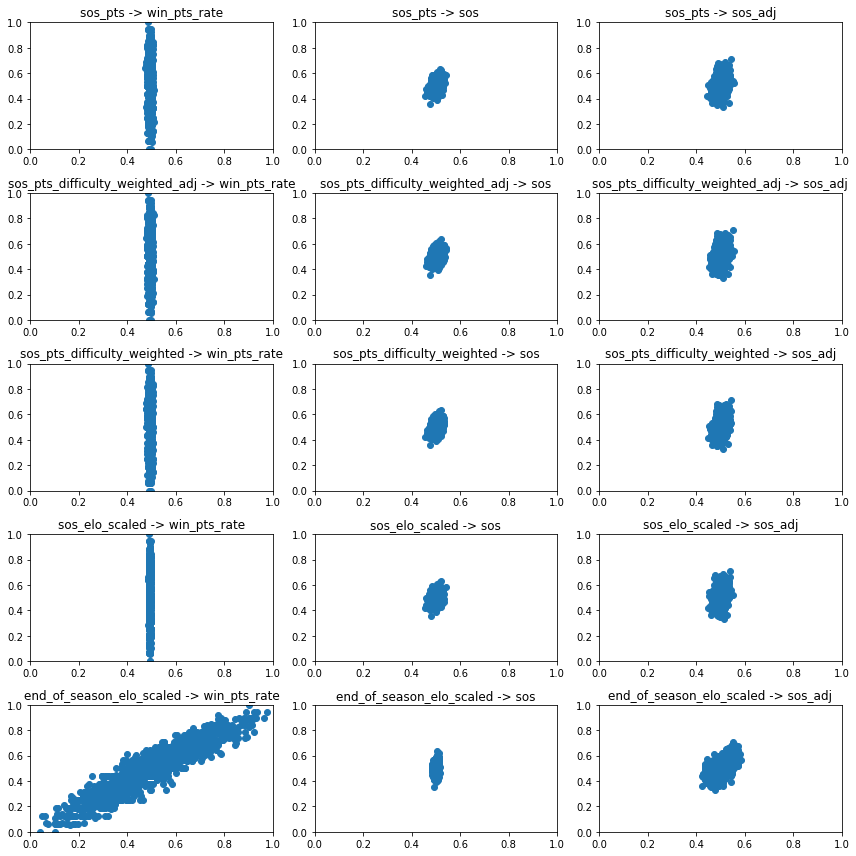

,R2,cols,predicting
9,0.000086,[sos_elo_scaled],win_pts_rate
3,0.000591,[sos_pts_difficulty_weighted_adj],win_pts_rate
6,0.000643,[sos_pts_difficulty_weighted],win_pts_rate
0,0.000683,[sos_pts],win_pts_rate
13,0.031591,[end_of_season_elo_scaled],sos
11,0.079389,[sos_elo_scaled],sos_adj
8,0.079655,[sos_pts_difficulty_weighted],sos_adj
5,0.080170,[sos_pts_difficulty_weighted_adj],sos_adj
2,0.083333,[sos_pts],sos_adj
7,0.122849,[sos_pts_difficulty_weighted],sos


In [22]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline


model_metrics_all=pd.DataFrame()
fig, axes = plt.subplots(len(columns),len(rows),figsize=(12, 12))
model_metrics=[]
for i,x_col in enumerate(columns):
    for j,y_col in enumerate(rows):
        X=dataset[[x_col]]
        X = sm.add_constant(X)
        y = dataset[y_col]
        model = sm.OLS(y, X)
        res = model.fit()
        model_metrics.append({
            "R2": res.rsquared,
            "cols": [x_col],
            "predicting": y_col
        })
        
        pred_ols = res.get_prediction()
        iv_l = pred_ols.summary_frame()["obs_ci_lower"]
        iv_u = pred_ols.summary_frame()["obs_ci_upper"]
        ax=axes[i][j]
        x_space=np.linspace(0,1,100)
        ax.scatter(res.fittedvalues, y, )
        ax.set_title(f"{x_col} -> {y_col}")
        ax.set_xlim(left=0,right=1)
        ax.set_ylim(bottom=0,top=1)
fig.tight_layout()
plt.show()
model_metrics_all=pd.concat([model_metrics_all,pd.DataFrame(model_metrics).sort_values(by=["R2"])])
model_metrics_all

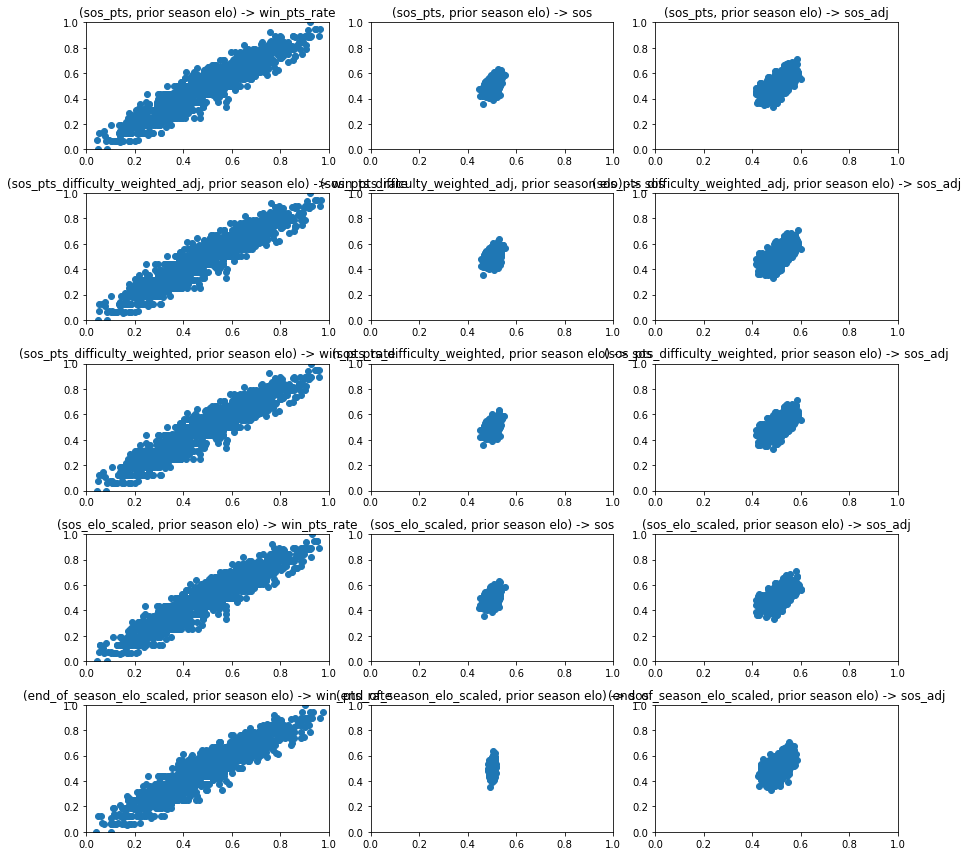

In [23]:


fig, axes = plt.subplots(len(columns),len(rows),figsize=(12, 12))
model_metrics=[]
for i,x_col in enumerate(columns):
    for j,y_col in enumerate(rows):
        X=dataset[[x_col,'end_of_season_elo_scaled']]
        X = sm.add_constant(X)
        y = dataset[y_col]
        model = sm.OLS(y, X)
        res = model.fit()
        model_metrics.append({
            "R2": res.rsquared,
            "cols": [x_col,"prior_season_elo"],
            "predicting": y_col
        })
        
        pred_ols = res.get_prediction()
        iv_l = pred_ols.summary_frame()["obs_ci_lower"]
        iv_u = pred_ols.summary_frame()["obs_ci_upper"]
        ax=axes[i][j]
        x_space=np.linspace(0,1,100)
        ax.scatter(res.fittedvalues, y, )
        ax.set_title(f"({x_col}, prior season elo) -> {y_col}")
        ax.set_xlim(left=0,right=1)
        ax.set_ylim(bottom=0,top=1)
fig.tight_layout()
plt.show()
model_metrics_all=pd.concat([model_metrics_all,pd.DataFrame(model_metrics).sort_values(by=["R2"])])


In [24]:
model_metrics_all.sort_values(by=["R2"],ascending=False)

,R2,cols,predicting
9,0.884685,"[sos_elo_scaled, prior_season_elo]",win_pts_rate
6,0.883405,"[sos_pts_difficulty_weighted, prior_season_elo]",win_pts_rate
3,0.882521,"[sos_pts_difficulty_weighted_adj, prior_season...",win_pts_rate
0,0.881560,"[sos_pts, prior_season_elo]",win_pts_rate
12,0.874948,[end_of_season_elo_scaled],win_pts_rate
12,0.874948,"[end_of_season_elo_scaled, prior_season_elo]",win_pts_rate
10,0.330107,"[sos_elo_scaled, prior_season_elo]",sos
4,0.323053,"[sos_pts_difficulty_weighted_adj, prior_season...",sos
1,0.320407,"[sos_pts, prior_season_elo]",sos
7,0.319274,"[sos_pts_difficulty_weighted, prior_season_elo]",sos


In [25]:
#model_metrics_all.sort_values(by=["R2"],ascending=False).to_csv("data/metrics_without_playoffs.csv",index=False)

Adjusted strength of schedule is a far more predictable metric based on end of season elo and prior season records. I recommend using adjusted SOS over normal SOS.

This isn't quite there yet. Need to tie into why this better predicts team skill independent of schedule. 

In [24]:
model_metrics=pd.read_csv("data/metrics_without_playoffs.csv").merge(pd.read_csv("data/metrics_with_playoffs.csv"), on=["cols","predicting"], suffixes=["","_with_playoffs"])
model_metrics['playoff_effect']=model_metrics['R2_with_playoffs']-model_metrics['R2']
model_metrics

,R2,cols,predicting,R2_with_playoffs,playoff_effect
0,0.884685,"['sos_elo_scaled', 'prior_season_elo']",win_pts_rate,0.882157,-0.002529
1,0.883405,"['sos_pts_difficulty_weighted', 'prior_season_...",win_pts_rate,0.880996,-0.002409
2,0.882521,"['sos_pts_difficulty_weighted_adj', 'prior_sea...",win_pts_rate,0.879902,-0.002620
3,0.881560,"['sos_pts', 'prior_season_elo']",win_pts_rate,0.879572,-0.001988
4,0.874948,['end_of_season_elo_scaled'],win_pts_rate,0.874587,-0.000361
5,0.874948,"['end_of_season_elo_scaled', 'prior_season_elo']",win_pts_rate,0.874587,-0.000361
6,0.330107,"['sos_elo_scaled', 'prior_season_elo']",sos,0.178628,-0.151480
7,0.323053,"['sos_pts_difficulty_weighted_adj', 'prior_sea...",sos,0.169684,-0.153369
8,0.320407,"['sos_pts', 'prior_season_elo']",sos,0.172219,-0.148187
9,0.319274,"['sos_pts_difficulty_weighted', 'prior_season_...",sos,0.170563,-0.148712
